In [0]:
from google.colab import drive
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from keras.models import model_from_json, Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, InputLayer, UpSampling2D

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

# drive.mount('/content/gdrive', force_remount = True)
# os.chdir('/content/gdrive/My Drive/Colab Notebooks')
!ls
os.chdir('drive/My Drive')

Using TensorFlow backend.


drive  sample_data


In [0]:
images = list()
for imagename in os.listdir('Dataset/Train/'):
    images.append(img_to_array(load_img('Dataset/Train/' + imagename)))

images       = np.array(images, dtype = float)
split        = int(0.7 * len(images)) #Use 70% of images for training

images_train = images[:split] * (1.0 / 255)

images_validation = images[split:] * (1.0 / 255)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [0]:
model = Sequential()

#Input Layer
model.add(Conv2D(64, (3, 3), input_shape=(256, 256, 1), activation = 'relu', padding = 'same'))

#Hidden Layers
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same', strides = 2))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same', strides = 2))
model.add(Conv2D(256, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(256, (3, 3), activation = 'relu', padding = 'same', strides = 2))
model.add(Conv2D(512, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(256, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(2, (3, 3), activation = 'tanh', padding = 'same'))
model.add(UpSampling2D((2, 2)))

#Compiling the CNN
# model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['accuracy'])
# model.compile(optimizer = 'sgd', loss = 'mean_squared_error', metrics = ['accuracy'])
model.compile(optimizer = 'sgd', loss = 'mean_squared_logarithmic_error', metrics = ['accuracy'])


In [0]:
datagen = ImageDataGenerator(zoom_range = 0.2, rotation_range = 20, horizontal_flip = True)

# Generate training data
def image_a_b_gen(batch_size):
    for batch in datagen.flow(images_train, batch_size = batch_size):
        lab_batch = rgb2lab(batch)
        X_batch   = lab_batch[:, :, :, 0]
        Y_batch   = lab_batch[:, :, :, 1:] / 128
        yield (X_batch.reshape(X_batch.shape + (1, )), Y_batch)

datagen_val = ImageDataGenerator(zoom_range = 0.2, rotation_range = 20, horizontal_flip = True)
def image_val_gen(batch_size):
    for batch in datagen_val.flow(images_validation, batch_size = batch_size):
        lab_batch = rgb2lab(batch)
        X_batch   = lab_batch[:, :, :, 0]
        Y_batch   = lab_batch[:, :, :, 1:] / 128
        yield (X_batch.reshape(X_batch.shape + (1, )), Y_batch)




In [0]:
trainedmodel = model.fit_generator(image_a_b_gen(batch_size = 10), epochs = 50, steps_per_epoch = 30,validation_data = image_val_gen(10), validation_steps=30)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
30/30 [==============================] - 18s 599ms/step - loss: 0.0079 - acc: 0.4063 - val_loss: 0.0077 - val_acc: 0.4157
Epoch 2/50
30/30 [==============================] - 14s 460ms/step - loss: 0.0075 - acc: 0.4319 - val_loss: 0.0080 - val_acc: 0.4012
Epoch 3/50
30/30 [==============================] - 14s 464ms/step - loss: 0.0072 - acc: 0.4174 - val_loss: 0.0074 - val_acc: 0.4261
Epoch 4/50
30/30 [==============================] - 14s 458ms/step - loss: 0.0074 - acc: 0.3968 - val_loss: 0.0072 - val_acc: 0.4050
Epoch 5/50
30/30 [==============================] - 14s 468ms/step - loss: 0.0074 - acc: 0.4250 - val_loss: 0.0071 - val_acc: 0.4140
Epoch 6/50
30/30 [==============================] - 14s 463ms/step - loss: 0.0068 - acc: 0.4112 - val_loss: 0.0075 - val_acc: 0.4248
Epoch 7/50
30/30 [==============================] - 14s 463ms/step - loss: 0.0079 - acc: 0.4090 - val_loss: 

In [0]:
print(trainedmodel.history.keys())
# Plot training & validation accuracy values
plt.plot(trainedmodel.history['acc'])
plt.plot(trainedmodel.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: ignored

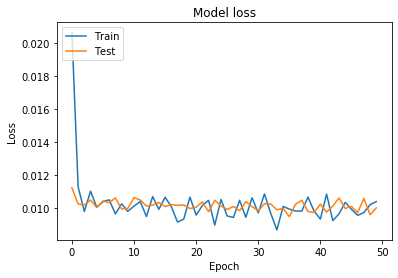

In [0]:
# Plot training & validation loss values
plt.plot(trainedmodel.history['loss'])
plt.plot(trainedmodel.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [0]:
json_file         = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")

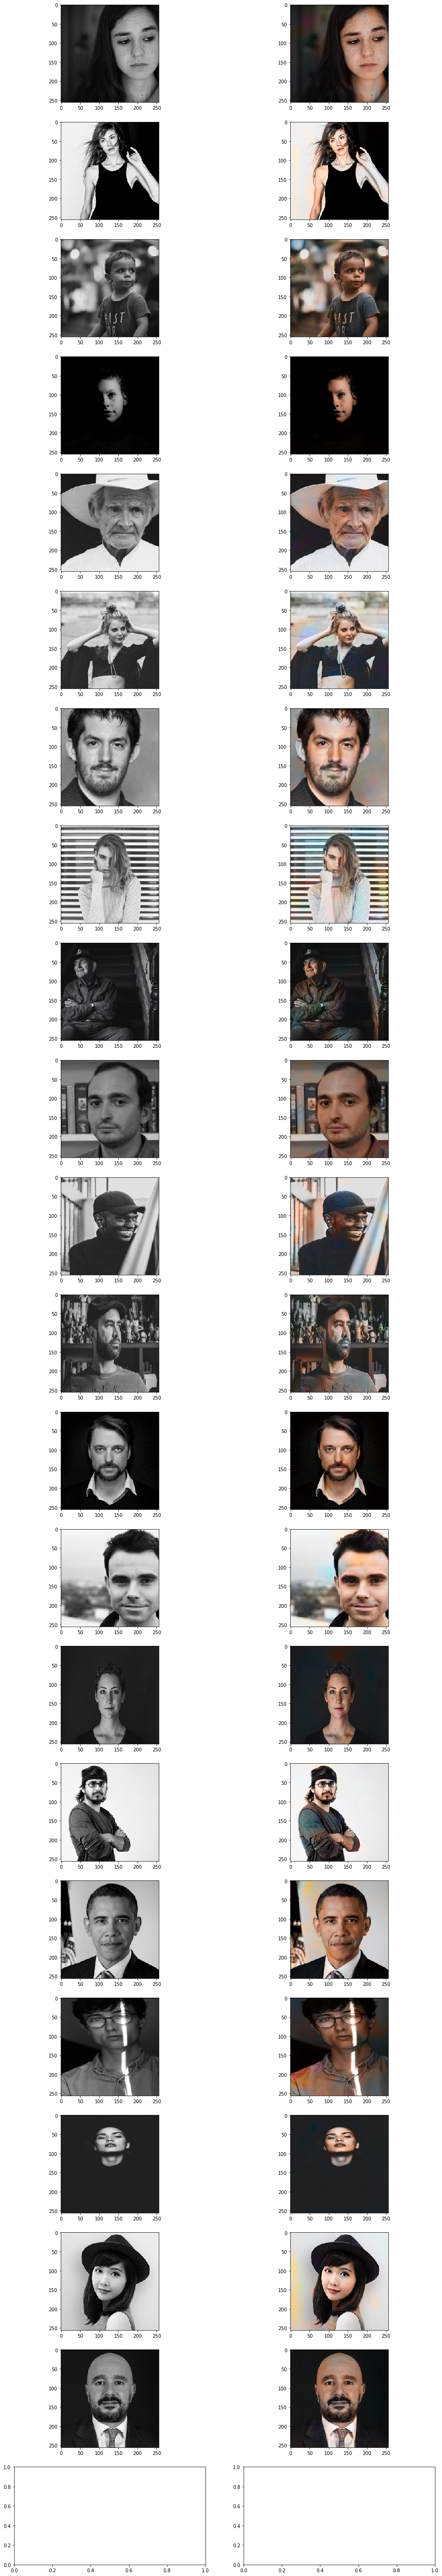

In [0]:
fig, ax  = plt.subplots(22, 2, figsize = (16, 100))
row      = int()
colorize = list()
for filename in os.listdir('Dataset/Test/'):
	colorize.append(img_to_array(load_img('Dataset/Test/' + filename)))
	ax[row, 0].imshow(load_img('Dataset/Test/' + filename), interpolation = 'nearest')
	row += 1

colorize = np.array(colorize, dtype=float)
colorize = rgb2lab((1.0 / 255) * colorize)[:, :, :, 0]
colorize = colorize.reshape(colorize.shape + (1, ))
output   = loaded_model.predict(colorize) * 128

row = 0
for i in range(len(output)):
	cur           = np.zeros((256, 256, 3))
	cur[:, :, 0]  = colorize[i][:, :, 0]
	cur[:, :, 1:] = output[i]
	resImage      = lab2rgb(cur)
	ax[row, 1].imshow(resImage)
	row += 1